In [1]:
import importlib
import utils
importlib.reload(utils)
from sent_sampling.utils import extract_pool,model_grps_config
import utils.optim_utils
importlib.reload(utils.optim_utils)
from sent_sampling.utils.optim_utils import optim, optim_pool, pt_create_corr_rdm_short
from sent_sampling.utils.data_utils import load_obj, SAVE_DIR, UD_PARENT, RESULTS_DIR, LEX_PATH_SET, save_obj
import torch 
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.spatial.distance import pdist, squareform
import matplotlib.cm as cm 
from tqdm import tqdm
import tsnecuda
import seaborn as sns 
import pandas as pd 
import os 
from sklearn.model_selection import LeaveOneOut
ANALYZE_DIR='/om/user/ehoseini/MyData/sent_sampling/analysis/'
from tqdm import tqdm
import tqdm.notebook as tq
from tqdm import tqdm_notebook

Loading lookup from /om/user/ehoseini/miniconda3/lib/python3.7/site-packages/brainio_collection/lookup.csv


/om/user/ehoseini/miniconda3/lib/python3.7/site-packages/brainscore/metrics/__init__.py:37: FutureWarning: xarray subclass Score should explicitly define __slots__
  class Score(DataAssembly):
/om/user/ehoseini/miniconda3/lib/python3.7/site-packages/torch/__init__.py:422: UserWarning: torch.set_deterministic is deprecated and will be removed in a future release. Please use torch.use_deterministic_algorithms instead
  "torch.set_deterministic is deprecated and will be removed in a future "
/om/user/ehoseini/miniconda3/lib/python3.7/site-packages/torch/__init__.py:422: UserWarning: torch.set_deterministic is deprecated and will be removed in a future release. Please use torch.use_deterministic_algorithms instead
  "torch.set_deterministic is deprecated and will be removed in a future "


In [2]:
mdl_name='gpt2'
scores = pd.read_csv(os.path.join(SAVE_DIR, 'scoresscoresscores', 'scores-Pereira2018-encoding-normalized.csv'))
score_layer = list(scores['layer'][scores['model'] == mdl_name])
score_benchmark = list(scores['benchmark'][scores['model'] == mdl_name])
score_score = np.asarray(scores['score'][scores['model'] == mdl_name])
score_error = np.asarray(scores['error'][scores['model'] == mdl_name])

In [3]:
model_classes=['glove','ETM','word2vec','lm_1b','skip-thoughts','bert-','roberta','xlm','xlm-roberta-'
    ,'transfo-xl','xlnet','ctrl','t5','albert-','gpt']
color_groups=['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds','YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
  'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

In [4]:
color_ids=[]
model_set=scores['model'].unique()
model_perf=[]
model_perf_untrained=[]
model_names=[]
model_layer_ids=[]
for model_id in model_set:
    model_score=scores['score'][scores['model']==model_id]
    model_error=scores['error'][scores['model']==model_id]
    model_layer_=scores['layer'][scores['model']==model_id]
    if model_id.find('untrained')==-1:
        model_perf.append([model_score.max(),model_error[model_score.idxmax()]])
        model_names.append(f"{model_id} ({model_layer_[model_score.idxmax()]})")
        model_layer_ids.append(model_layer_)
        # get untrained score 
        model_score_untr=list(scores['score'][scores['model']==f"{model_id}-untrained"])
        model_error_untr=list(scores['error'][scores['model']==f"{model_id}-untrained"])  
        model_perf_untrained.append([model_score_untr[np.argmax(model_score)],model_error_untr[np.argmax(model_score)]])
        if model_id=='xlm-roberta-base' or model_id=='xlm-roberta-large':
                color_loc=8
        else:
                color_loc=int(np.argwhere([model_id.find(x)!=-1  for x in model_classes])[-1].squeeze())
        color_ids.append(color_loc)



In [7]:
num_cols=[len(np.where(np.asarray(color_ids)==x)[0]) for idx, x in enumerate(np.unique(color_ids))]
h0s=[cm.get_cmap(color_groups[x],num_cols[idx]+2) for idx, x in enumerate(np.unique(color_ids))]
all_colors=[np.flipud(x(np.arange(num_cols[idx])/(num_cols[idx]+1))) for idx, x in enumerate(h0s)]
    #all_colors=[x(np.arange(num_cols[idx])/(num_cols[idx]+1)) for idx, x in enumerate(h0s)],
all_colors = [item for sublist in all_colors for item in sublist]

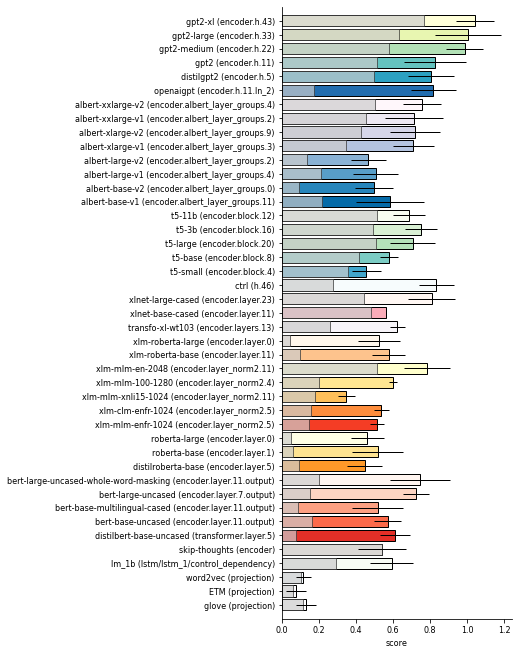

In [65]:
y_pos = np.arange(len(model_names))
fig=plt.figure(figsize=(8,10))
ax = fig.add_axes((.5,.1,.4,.85))
ax.barh(y_pos, np.asarray(model_perf)[:,0],height=.8, xerr=np.asarray(model_perf)[:,1], align='center',color=np.asarray(all_colors),edgecolor=(0,0,0),linewidth=1,error_kw={'linewidth':1})
#ax.barh(y_pos, np.asarray(model_perf_untrained)[:,0],height=0.8, align='center',color=np.asarray(all_colors),edgecolor=(.2,.2,.2),linewidth=1)
ax.barh(y_pos, np.asarray(model_perf_untrained)[:,0],height=0.8, align='center',color=(.8,.8,.8),edgecolor=(.2,.2,.2),linewidth=1,alpha=.7)
#ax.scatter(np.asarray(model_perf_untrained)[:,0],y_pos,s=20,zorder=10)
ax.set_yticks(y_pos)
ax.set_ylim(y_pos.min()-1,y_pos.max()+1)
ax.set_yticklabels(model_names,fontsize=8,fontweight='normal')
ax.tick_params(axis='x', which='both', labelsize=8)
ax.set_xlabel('score',fontsize=8)
plt.xticks(fontsize=8)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.savefig(os.path.join(ANALYZE_DIR,'schrimpf_2021_preira_model_scores.pdf'),transparent=True)

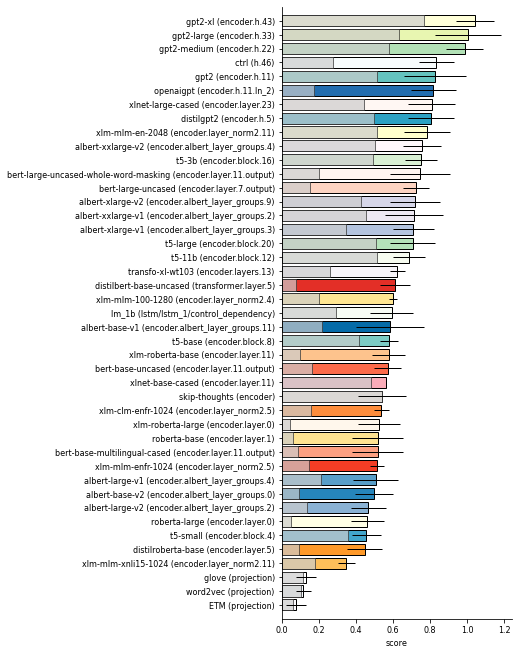

In [70]:
y_pos = np.arange(len(model_names))
fig=plt.figure(figsize=(8,10))
ax = fig.add_axes((.5,.1,.4,.85))
new_order=np.argsort(np.asarray(model_perf)[:,0])
ax.barh(y_pos, np.asarray(model_perf)[new_order,0],height=.8, xerr=np.asarray(model_perf)[new_order,1], align='center',color=np.asarray(all_colors)[new_order,:],edgecolor=(0,0,0),linewidth=1,error_kw={'linewidth':1})
ax.barh(y_pos, np.asarray(model_perf_untrained)[new_order,0],height=0.8, align='center',color=(.8,.8,.8),edgecolor=(.2,.2,.2),linewidth=1,alpha=.7)
ax.set_yticks(y_pos)
model_names_order=[model_names[x] for x in new_order]
ax.set_ylim(y_pos.min()-1,y_pos.max()+1)
ax.set_yticklabels(model_names_order,fontsize=8,fontweight='normal')
ax.tick_params(axis='x', which='both', labelsize=8)
ax.set_xlabel('score',fontsize=8)
plt.xticks(fontsize=8)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.savefig(os.path.join(ANALYZE_DIR,'schrimpf_2021_preira_model_scores_ordered.pdf'),transparent=True)


(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

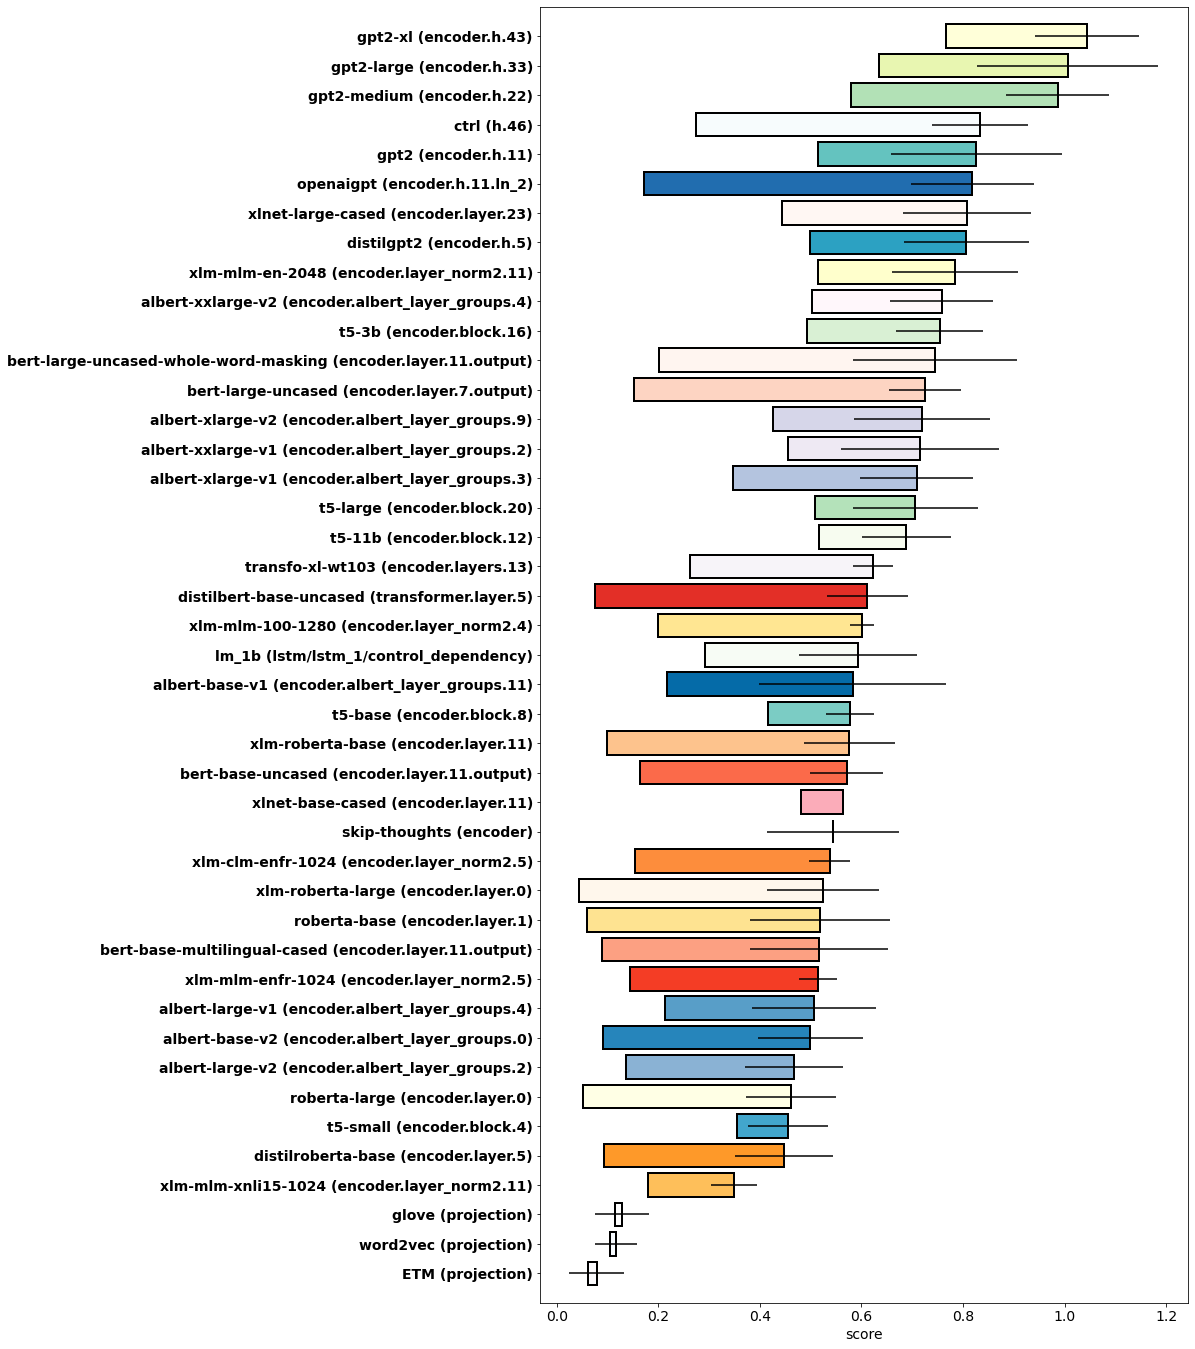

In [9]:
y_pos = np.arange(len(model_names))
fig=plt.figure(figsize=(15,20))
ax = fig.add_axes((.3,.05,.6,.9))
new_order=np.argsort(np.asarray(model_perf)[:,0])
baselines=np.asarray(model_perf_untrained)[new_order,0]
ax.barh(y_pos, np.asarray(model_perf)[new_order,0]-baselines,left=baselines, xerr=np.asarray(model_perf)[new_order,1], align='center',color=np.asarray(all_colors)[new_order,:],edgecolor=(0,0,0),linewidth=2),
#ax.barh(y_pos, np.asarray(model_perf_untrained)[new_order,0],height=0.8, align='center',color=(1,1,1),edgecolor=(1,1,1),linewidth=2)
ax.set_yticks(y_pos)
model_names_order=[model_names[x] for x in new_order]
ax.set_ylim(y_pos.min()-1,y_pos.max()+1)
ax.set_yticklabels(model_names_order,fontsize=14,fontweight='bold')
ax.set_xlabel('score',fontsize=14)
plt.xticks(fontsize=14)

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

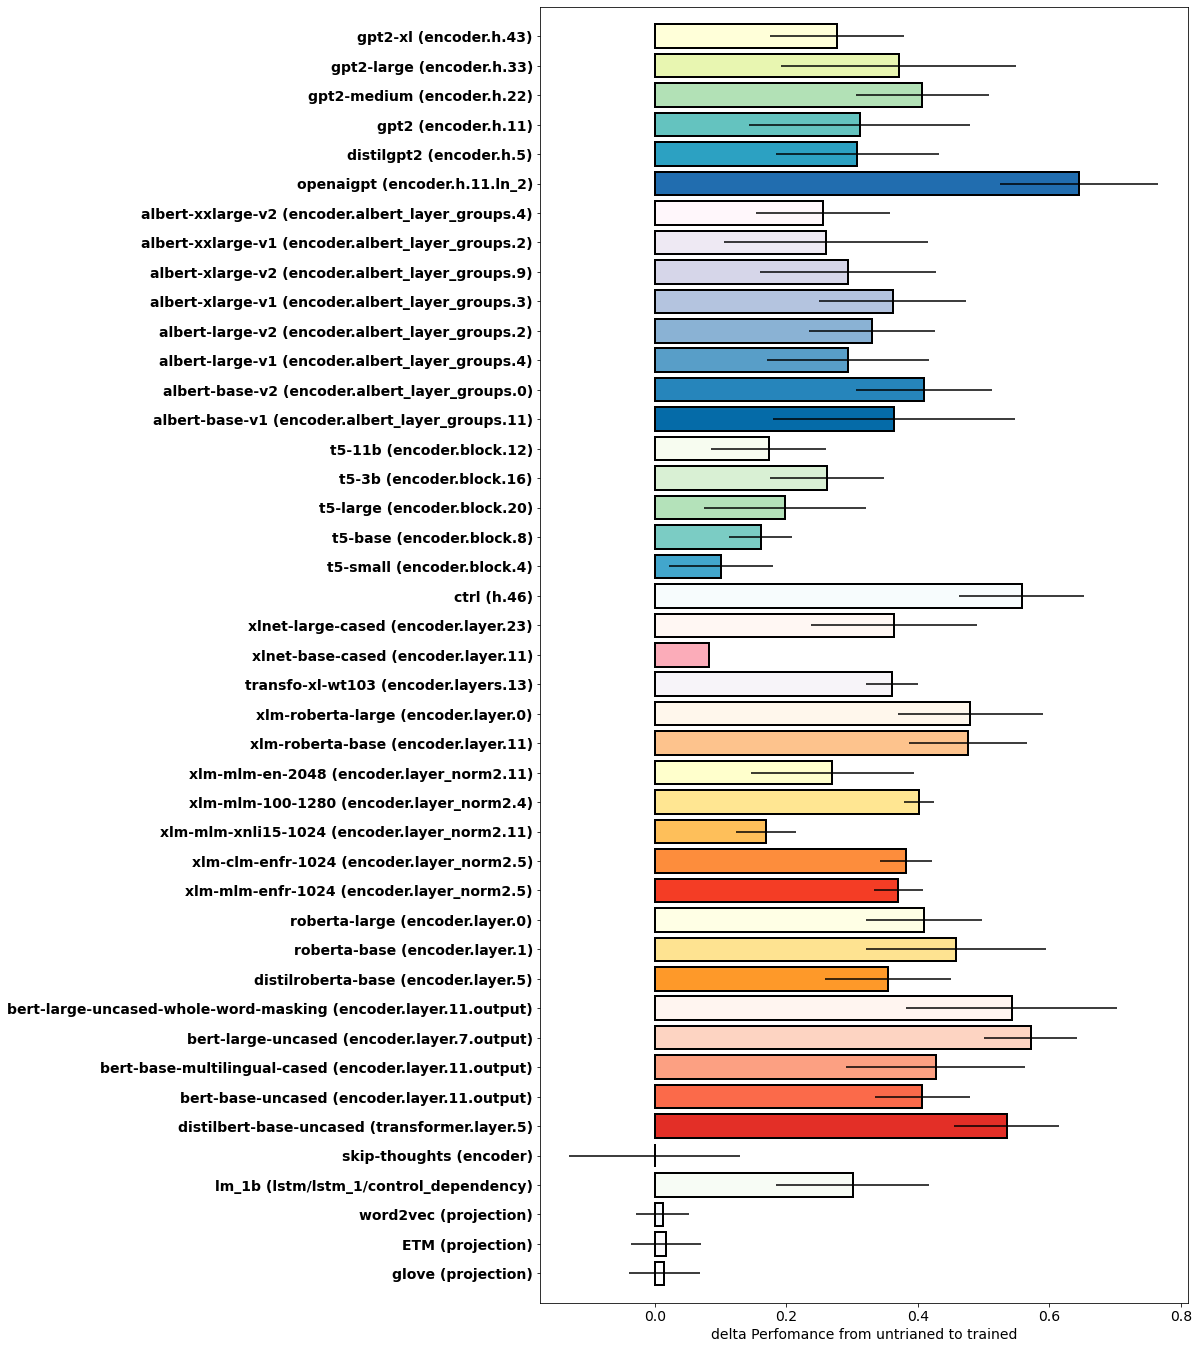

In [10]:
y_pos = np.arange(len(model_names))
fig=plt.figure(figsize=(15,20))
ax = fig.add_axes((.3,.05,.6,.9))
ax.barh(y_pos, np.asarray(model_perf)[:,0]-np.asarray(model_perf_untrained)[:,0], xerr=np.asarray(model_perf)[:,1], align='center',color=np.asarray(all_colors),edgecolor=(0,0,0),linewidth=2)
#ax.barh(y_pos, np.asarray(model_perf_untrained)[:,0],height=0.2, align='center',color=np.asarray(all_colors),edgecolor=(.2,.2,.2),linewidth=2)
ax.set_yticks(y_pos)
ax.set_yticklabels(model_names,fontsize=12,fontweight='bold')
ax.set_xlabel('delta Perfomance from untrianed to trained',fontsize=14)

ax.set_ylim(y_pos.min()-1,y_pos.max()+1)
ax.set_yticklabels(model_names,fontsize=14,fontweight='bold')
plt.xticks(fontsize=14)

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

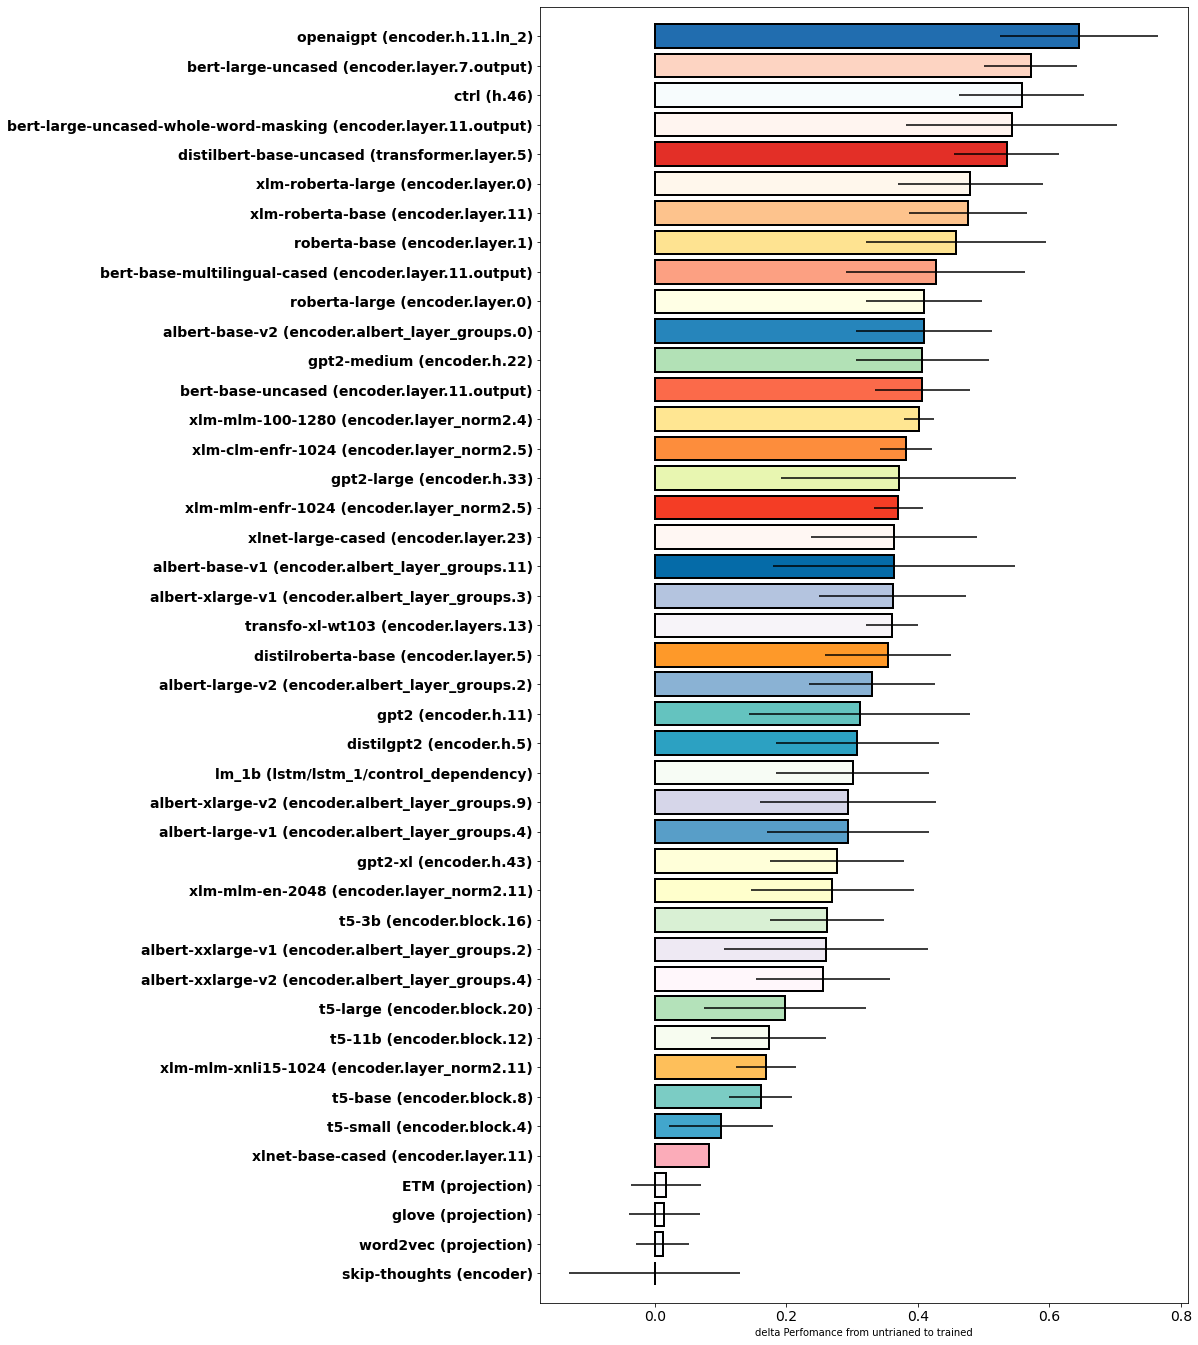

In [11]:
y_pos = np.arange(len(model_names))
fig=plt.figure(figsize=(15,20))
ax = fig.add_axes((.3,.05,.6,.9))
perf_diff=np.asarray(model_perf)[:,0]-np.asarray(model_perf_untrained)[:,0]
new_order=np.argsort(perf_diff)
ax.barh(y_pos, perf_diff[new_order], xerr=np.asarray(model_perf)[new_order,1], align='center',color=np.asarray(all_colors)[new_order,:],edgecolor=(0,0,0),linewidth=2),
model_names_order=[model_names[x] for x in new_order]
ax.set_yticks(y_pos)

ax.set_xlabel('delta Perfomance from untrianed to trained')

ax.set_ylim(y_pos.min()-1,y_pos.max()+1)
ax.set_yticklabels(model_names_order,fontsize=14,fontweight='bold')
plt.xticks(fontsize=14)

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

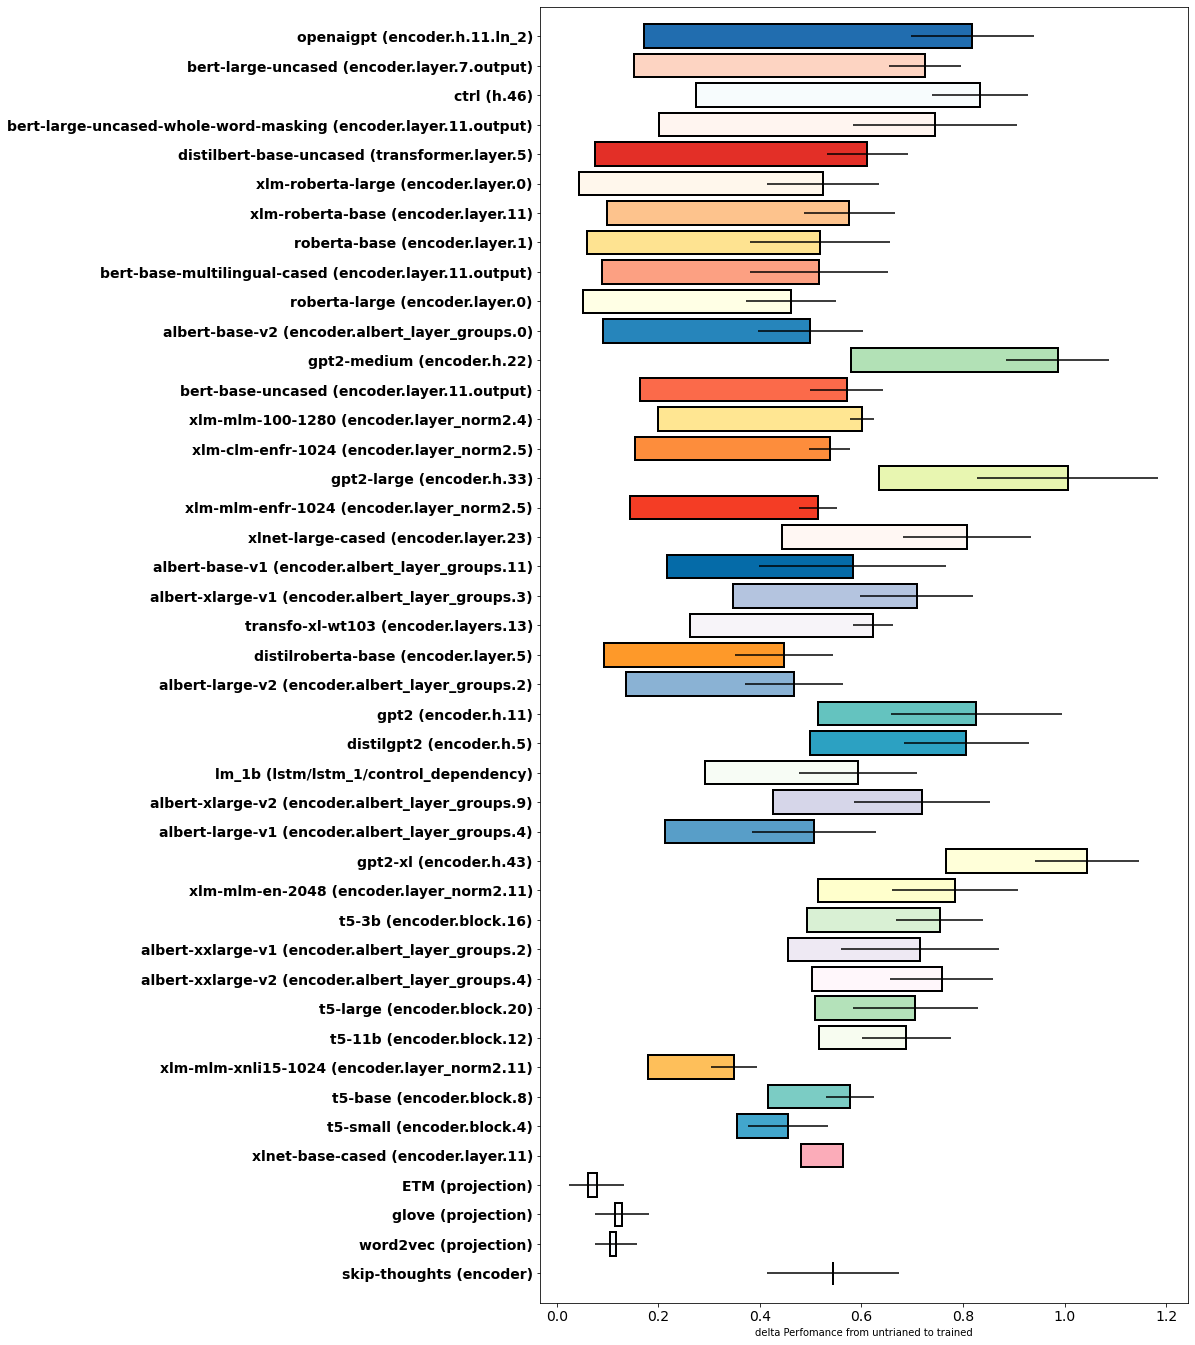

In [12]:
y_pos = np.arange(len(model_names))
fig=plt.figure(figsize=(15,20))
ax = fig.add_axes((.3,.05,.6,.9))
perf_diff=np.asarray(model_perf)[:,0]-np.asarray(model_perf_untrained)[:,0]
new_order=np.argsort(perf_diff)
baseline_perf=np.asarray(model_perf_untrained)[:,0]
ax.barh(y_pos, perf_diff[new_order], xerr=np.asarray(model_perf)[new_order,1],left=baseline_perf[new_order],align='center',color=np.asarray(all_colors)[new_order,:],edgecolor=(0,0,0),linewidth=2),
model_names_order=[model_names[x] for x in new_order]
ax.set_yticks(y_pos)

ax.set_xlabel('delta Perfomance from untrianed to trained')

ax.set_ylim(y_pos.min()-1,y_pos.max()+1)
ax.set_yticklabels(model_names_order,fontsize=14,fontweight='bold')
plt.xticks(fontsize=14)

/om/user/ehoseini/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()


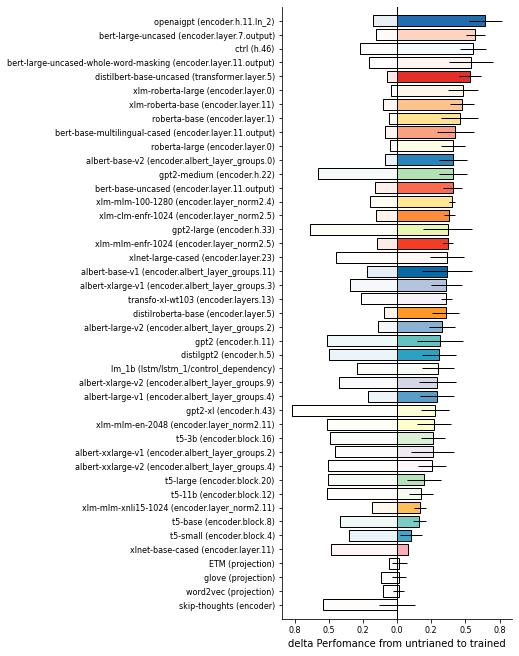

In [91]:
y_pos = np.arange(len(model_names))
fig=plt.figure(figsize=(8,10))
ax = fig.add_axes((.5,.1,.4,.85))
perf_diff=np.asarray(model_perf)[:,0]-np.asarray(model_perf_untrained)[:,0]
new_order=np.argsort(perf_diff)
baseline_perf=np.asarray(model_perf_untrained)[:,0]
ax.barh(y_pos, perf_diff[new_order], xerr=np.asarray(model_perf)[new_order,1],align='center',color=np.asarray(all_colors)[new_order,:],edgecolor=(0,0,0),linewidth=1,error_kw={'linewidth':1}),
ax.barh(y_pos, -1*baseline_perf[new_order],align='center',color=np.asarray(all_colors)[new_order,:],edgecolor=(0,0,0),linewidth=1,alpha=.1),
ax.barh(y_pos, -1*baseline_perf[new_order],align='center',fill=False,color=None,edgecolor=(0,0,0),linewidth=1,alpha=1),
ax.set_ylim(y_pos.min()-1,y_pos.max()+1)
ax.plot([0,0],[y_pos.min()-1,y_pos.max()+1],'k-',linewidth=1)

model_names_order=[model_names[x] for x in new_order]
ax.set_yticks(y_pos)
labels = ["{0:.1f}".format(x) for x in np.abs(ax.get_xticks())]
ax.set_xticklabels(labels)
ax.set_xlabel('delta Perfomance from untrianed to trained')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_yticklabels(model_names_order,fontsize=8,fontweight='normal')
plt.xticks(fontsize=8)
fig.savefig(os.path.join(ANALYZE_DIR,'schrimpf_2021_preira_delta_score_ordered.pdf'),transparent=True)

# Behavoral scores 


In [14]:
scores = pd.read_csv(os.path.join(SAVE_DIR, 'scoresscoresscores', 'scores-Futrell2018-encoding-normalized.csv'))
score_layer = list(scores['layer'][scores['model'] == mdl_name])
score_benchmark = list(scores['benchmark'][scores['model'] == mdl_name])
score_score = np.asarray(scores['score'][scores['model'] == mdl_name])
score_error = np.asarray(scores['error'][scores['model'] == mdl_name])

In [15]:
model_classes=['glove','ETM','word2vec','lm_1b','skip-thoughts','bert-','roberta','xlm','xlm-roberta-'
    ,'transfo-xl','xlnet','ctrl','t5','albert-','gpt','transformer']
color_groups=['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds','YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
  'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

In [16]:
color_ids=[]
model_set=scores['model'].unique()
model_perf=[]
model_perf_untrained=[]
model_names=[]
model_layer_ids=[]
for model_id in model_set:
    model_score=scores['score'][scores['model']==model_id]
    model_error=scores['error'][scores['model']==model_id]
    model_layer_=scores['layer'][scores['model']==model_id]
    if model_id.find('untrained')==-1:
        model_perf.append([model_score.max(),model_error[model_score.idxmax()]])
        model_names.append(f"{model_id} ({model_layer_[model_score.idxmax()]})")
        model_layer_ids.append(model_layer_)
        # get untrained score 
        model_score_untr=list(scores['score'][scores['model']==f"{model_id}-untrained"])
        model_error_untr=list(scores['error'][scores['model']==f"{model_id}-untrained"])  
        model_perf_untrained.append([model_score_untr[np.argmax(model_score)],model_error_untr[np.argmax(model_score)]])


        if model_id=='xlm-roberta-base' or model_id=='xlm-roberta-large':
                color_loc=8
        else:
                color_loc=int(np.argwhere([model_id.find(x)!=-1  for x in model_classes])[-1].squeeze())
        color_ids.append(color_loc)

In [17]:
num_cols=[len(np.where(np.asarray(color_ids)==x)[0]) for idx, x in enumerate(np.unique(color_ids))]
h0s=[cm.get_cmap(color_groups[x],num_cols[idx]+2) for idx, x in enumerate(np.unique(color_ids))]
all_colors=[np.flipud(x(np.arange(num_cols[idx])/(num_cols[idx]+1))) for idx, x in enumerate(h0s)]
    #all_colors=[x(np.arange(num_cols[idx])/(num_cols[idx]+1)) for idx, x in enumerate(h0s)],
all_colors = [item for sublist in all_colors for item in sublist]

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

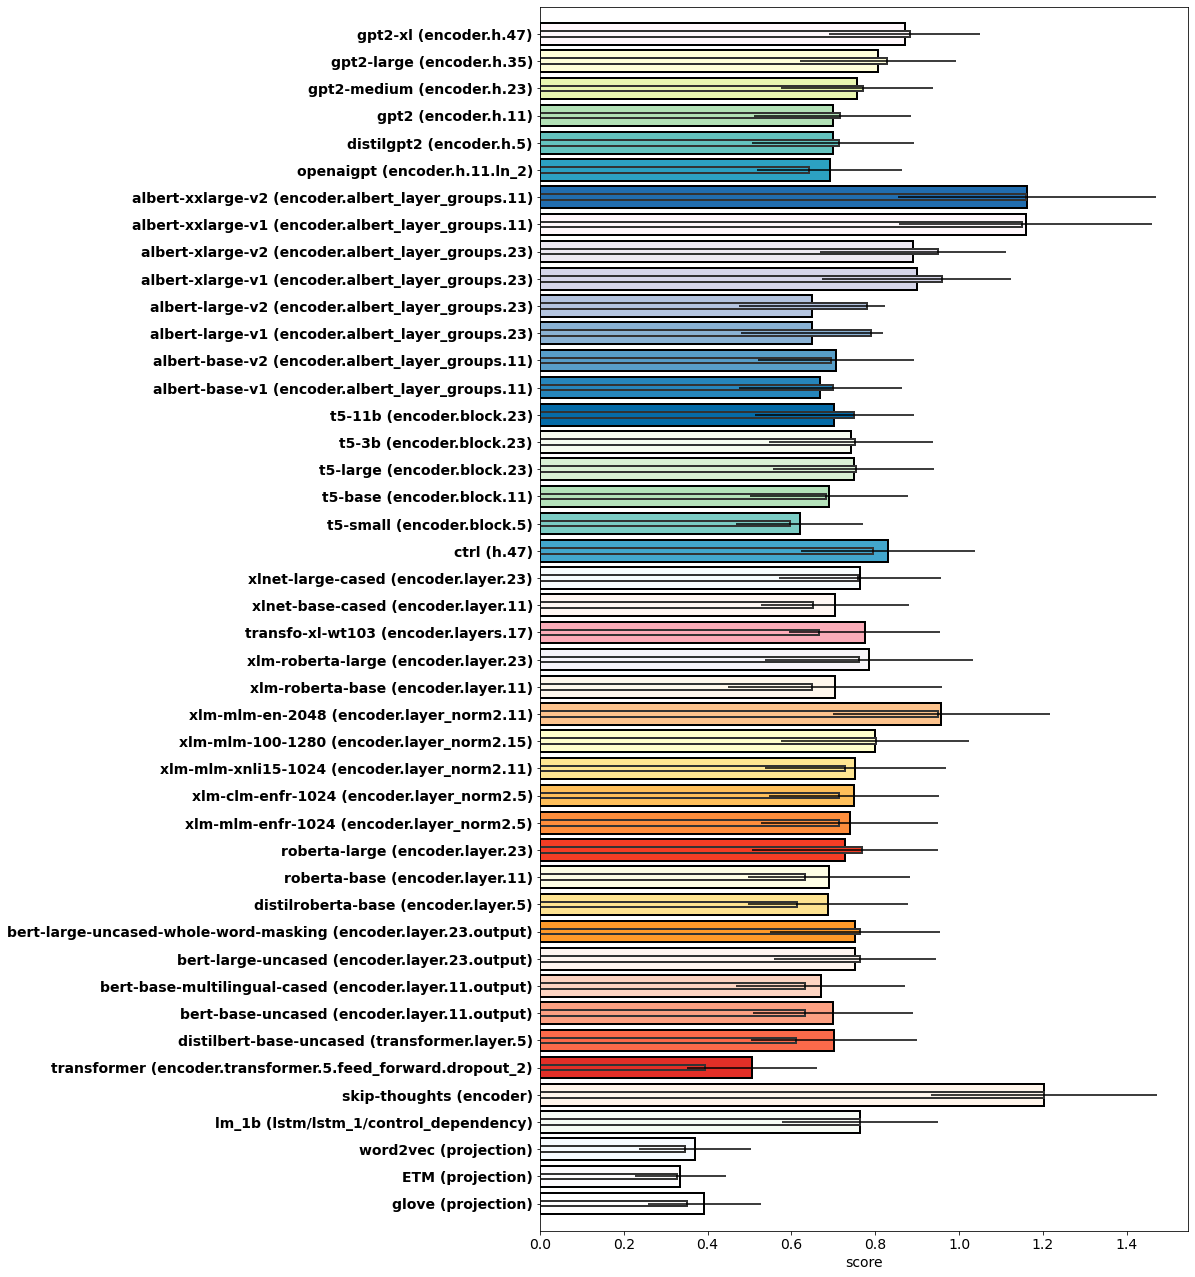

In [18]:
y_pos = np.arange(len(model_names))
fig=plt.figure(figsize=(15,20))
ax = fig.add_axes((.3,.1,.6,.85))
ax.barh(y_pos, np.asarray(model_perf)[:,0], xerr=np.asarray(model_perf)[:,1], align='center',color=np.asarray(all_colors),edgecolor=(0,0,0),linewidth=2)
ax.barh(y_pos, np.asarray(model_perf_untrained)[:,0],height=0.2, align='center',color=np.asarray(all_colors),edgecolor=(.2,.2,.2),linewidth=2)
ax.set_yticks(y_pos)
ax.set_ylim(y_pos.min()-1,y_pos.max()+1)
ax.set_yticklabels(model_names,fontsize=14,fontweight='bold')
ax.set_xlabel('score',fontsize=14)
plt.xticks(fontsize=14)

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

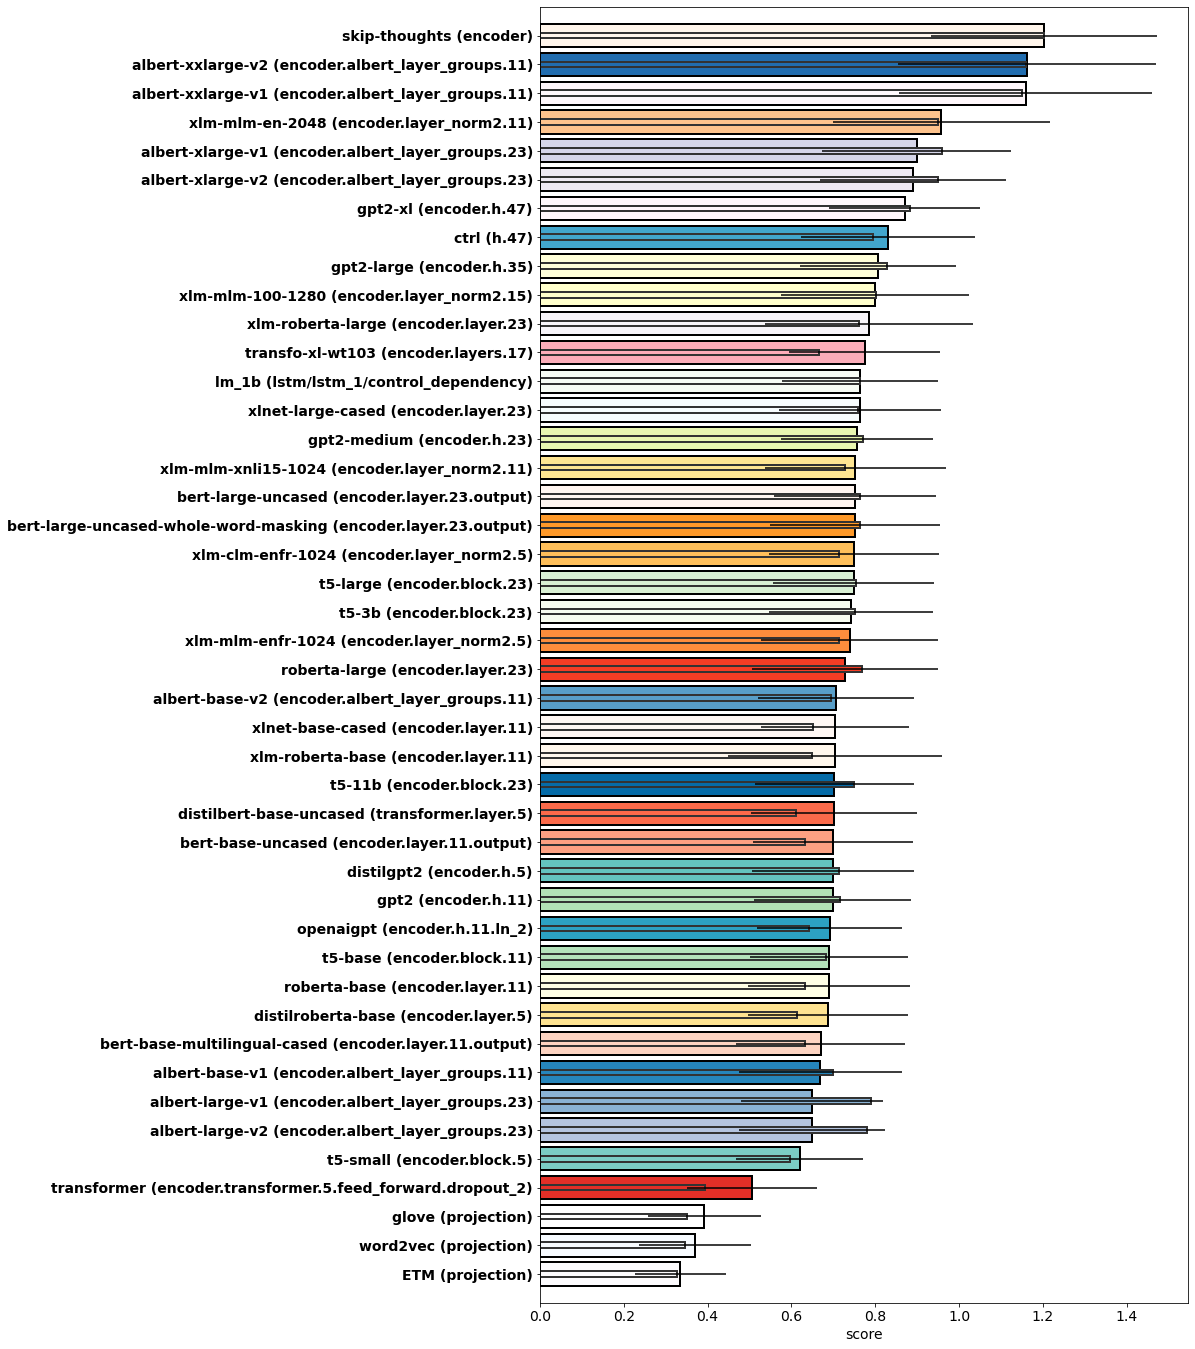

In [19]:
y_pos = np.arange(len(model_names))
fig=plt.figure(figsize=(15,20))
ax = fig.add_axes((.3,.05,.6,.9))
new_order=np.argsort(np.asarray(model_perf)[:,0])
ax.barh(y_pos, np.asarray(model_perf)[new_order,0], xerr=np.asarray(model_perf)[new_order,1], align='center',color=np.asarray(all_colors)[new_order,:],edgecolor=(0,0,0),linewidth=2),
ax.barh(y_pos, np.asarray(model_perf_untrained)[new_order,0],height=0.2, align='center',color=np.asarray(all_colors)[new_order,:],edgecolor=(.2,.2,.2),linewidth=2)
ax.set_yticks(y_pos)
model_names_order=[model_names[x] for x in new_order]
ax.set_ylim(y_pos.min()-1,y_pos.max()+1)
ax.set_yticklabels(model_names_order,fontsize=14,fontweight='bold')
ax.set_xlabel('score',fontsize=14)
plt.xticks(fontsize=14)

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

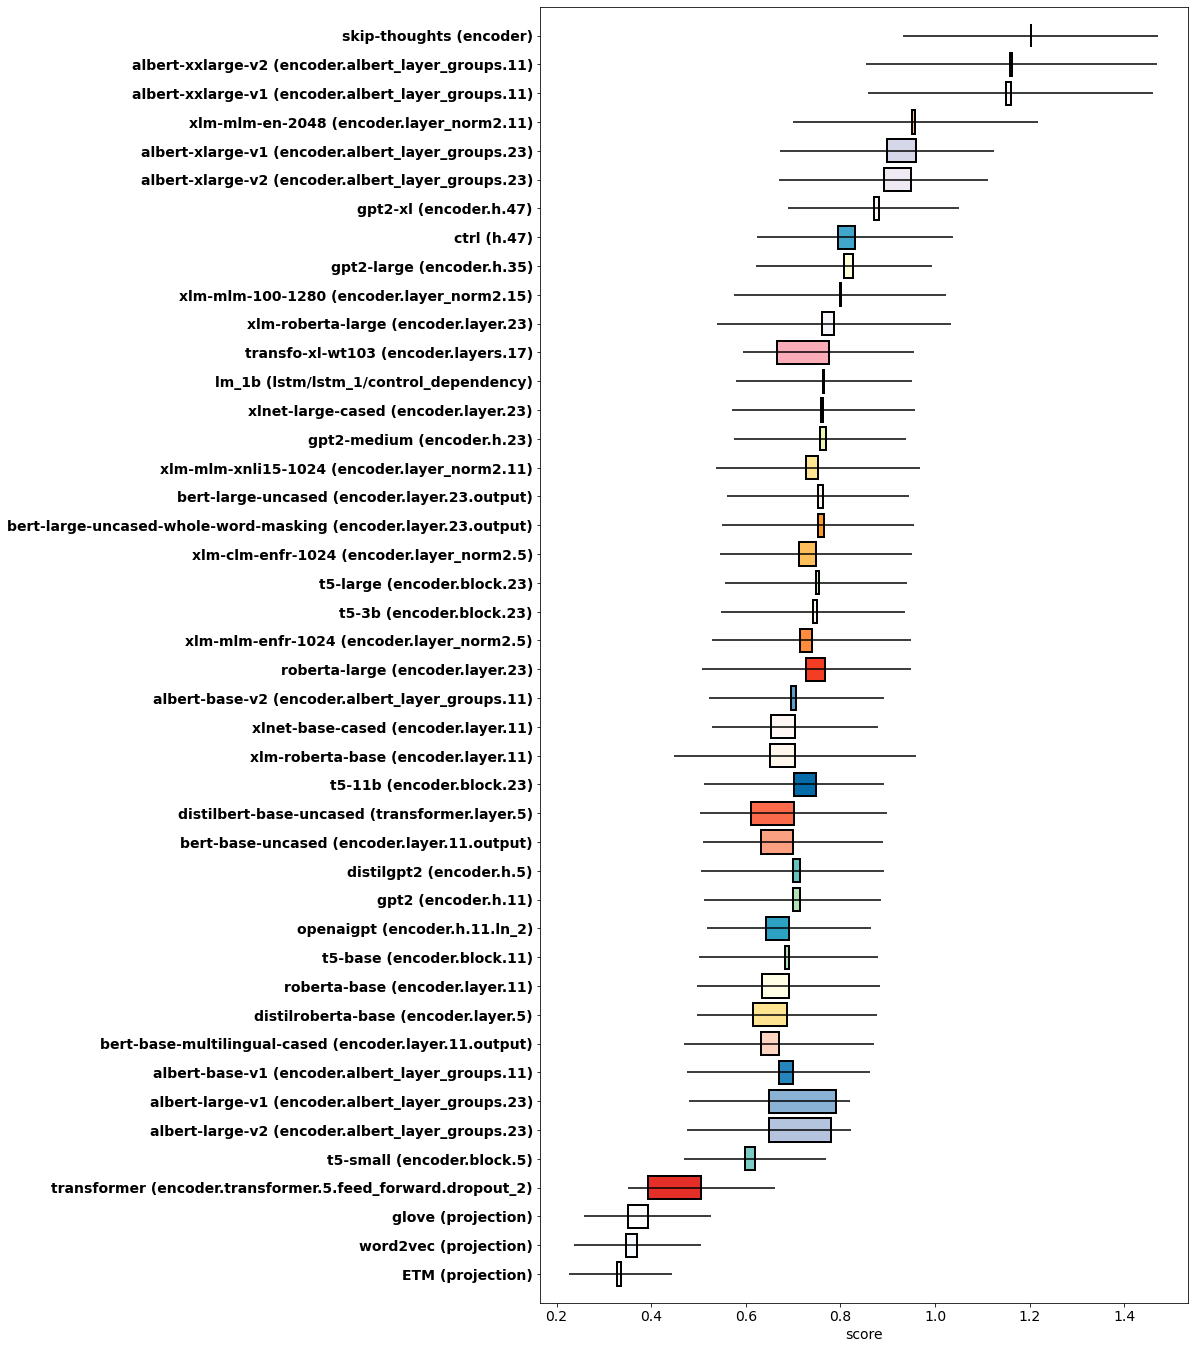

In [20]:
y_pos = np.arange(len(model_names))
fig=plt.figure(figsize=(15,20))
ax = fig.add_axes((.3,.05,.6,.9))
new_order=np.argsort(np.asarray(model_perf)[:,0])
baselines=np.asarray(model_perf_untrained)[new_order,0]
ax.barh(y_pos, np.asarray(model_perf)[new_order,0]-baselines,left=baselines, xerr=np.asarray(model_perf)[new_order,1], align='center',color=np.asarray(all_colors)[new_order,:],edgecolor=(0,0,0),linewidth=2),
#ax.barh(y_pos, np.asarray(model_perf_untrained)[new_order,0],height=0.8, align='center',color=(1,1,1),edgecolor=(1,1,1),linewidth=2)
ax.set_yticks(y_pos)
model_names_order=[model_names[x] for x in new_order]
ax.set_ylim(y_pos.min()-1,y_pos.max()+1)
ax.set_yticklabels(model_names_order,fontsize=14,fontweight='bold')
ax.set_xlabel('score',fontsize=14)
plt.xticks(fontsize=14)

(array([-0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

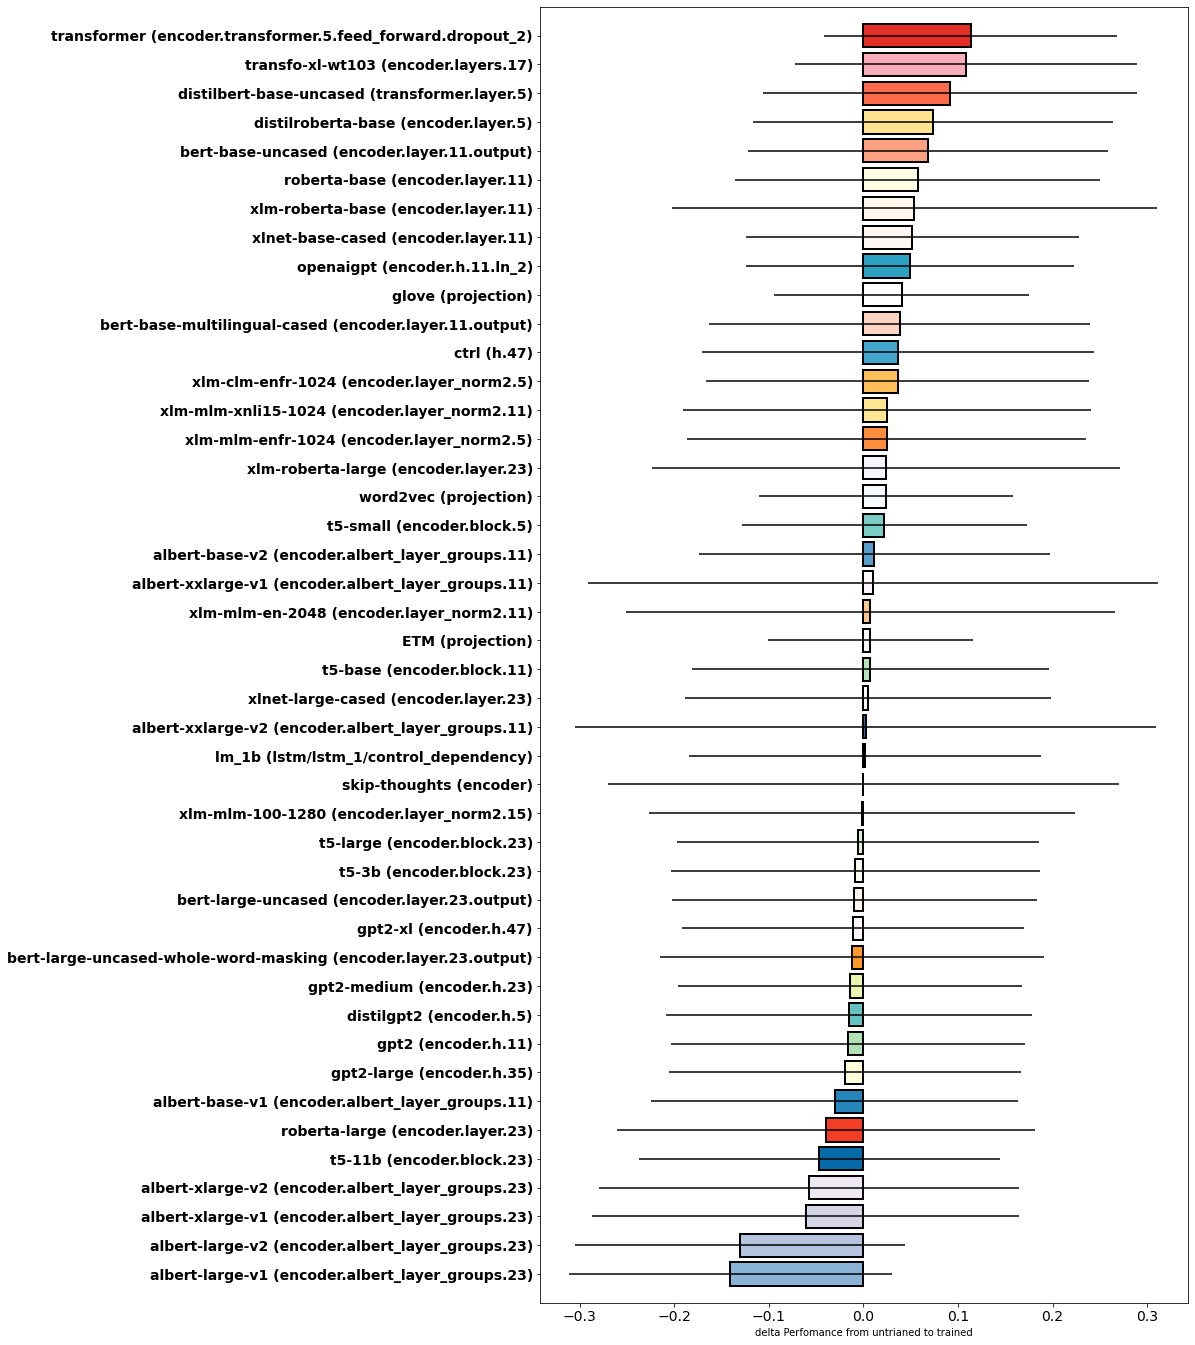

In [21]:
y_pos = np.arange(len(model_names))
fig=plt.figure(figsize=(15,20))
ax = fig.add_axes((.3,.05,.6,.9))
perf_diff=np.asarray(model_perf)[:,0]-np.asarray(model_perf_untrained)[:,0]
new_order=np.argsort(perf_diff)
ax.barh(y_pos, perf_diff[new_order], xerr=np.asarray(model_perf)[new_order,1], align='center',color=np.asarray(all_colors)[new_order,:],edgecolor=(0,0,0),linewidth=2),
model_names_order=[model_names[x] for x in new_order]
ax.set_yticks(y_pos)

ax.set_xlabel('delta Perfomance from untrianed to trained')

ax.set_ylim(y_pos.min()-1,y_pos.max()+1)
ax.set_yticklabels(model_names_order,fontsize=14,fontweight='bold')
plt.xticks(fontsize=14)

/om/user/ehoseini/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


Text(0.5, 0.98, 'Futrell2018')

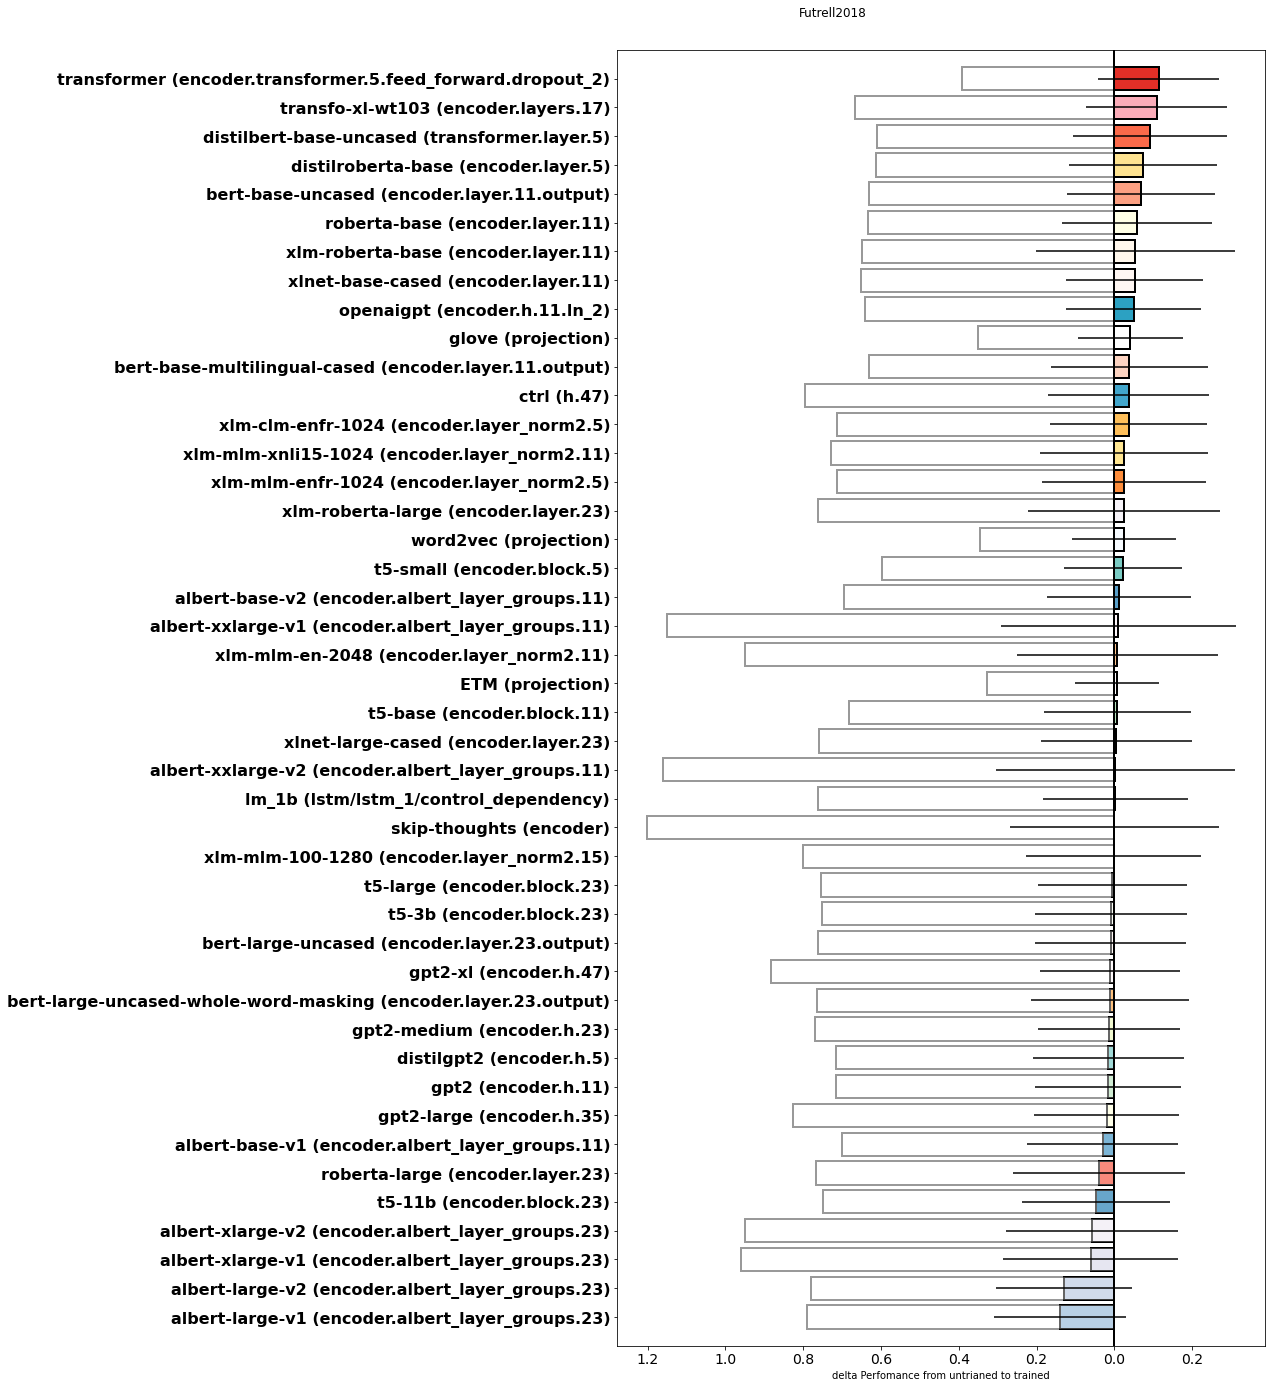

In [22]:
y_pos = np.arange(len(model_names))
fig=plt.figure(figsize=(15,20))
ax = fig.add_axes((.3,.05,.6,.9))
perf_diff=np.asarray(model_perf)[:,0]-np.asarray(model_perf_untrained)[:,0]
new_order=np.argsort(perf_diff)
baseline_perf=np.asarray(model_perf_untrained)[:,0]
ax.barh(y_pos, perf_diff[new_order], xerr=np.asarray(model_perf)[new_order,1],align='center',color=np.asarray(all_colors)[new_order,:],edgecolor=(0,0,0),linewidth=2),
ax.barh(y_pos, -1*baseline_perf[new_order],align='center',color=(1,1,1),edgecolor=(0,0,0),linewidth=2,alpha=.4),
ax.set_ylim(y_pos.min()-1,y_pos.max()+1)
ax.plot([0,0],[y_pos.min()-1,y_pos.max()+1],'k-',linewidth=2)

model_names_order=[model_names[x] for x in new_order]
ax.set_yticks(y_pos)
labels = ["{0:.1f}".format(x) for x in np.abs(ax.get_xticks())]
ax.set_xticklabels(labels)
ax.set_xlabel('delta Perfomance from untrianed to trained')


ax.set_yticklabels(model_names_order,fontsize=16,fontweight='bold')
plt.xticks(fontsize=14)
plt.suptitle('Futrell2018',fontsize=12)